In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import MFKSFVEvolve as fv
from MFKSSteadyState import get_P_ss, get_lbd_0, get_lbd_inf
from utils import reparameterize


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [113]:
n_grid = 50
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-0
r = 1e-4

lbd_spl = 30.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)
g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

# _, stat = fv.evolve_P_from_gauss(10000, 100, 0.01, n_grid, fact, kappa, k, eps, lbd_spl, r, 5, 1)

P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 5**2) # high sigma ini
# P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 0.3**2) # low sigma ini

xmax = lbd_spl + 5.0
x_ss, P_ss = get_P_ss(xmax, kappa, k, eps, lbd_spl, r)


Emerging scales: lbd_spl/2 = 15.00, lbd_max = 11.28, lbd_spl = 30.00
Parameters do not produce a steady state solution.


AssertionError: Parameters do not produce a steady state solution.

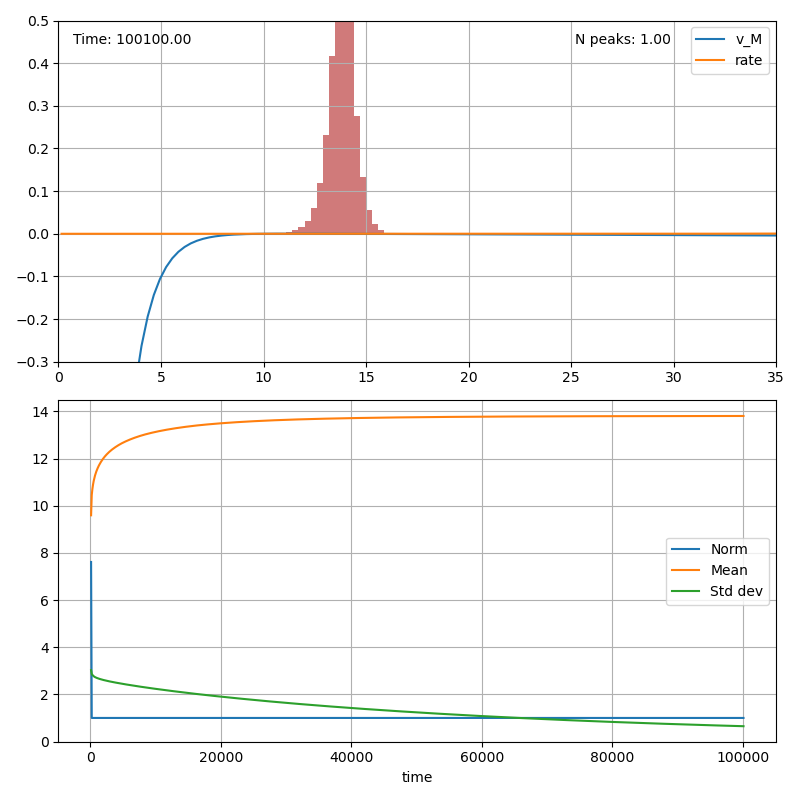

In [116]:
# animate P(t)
num_frames = 1000
dt = 0.1
stride = 1000

# Initial state
P = P_ini

# Initialize plot
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
ax1 = axs[0]
bars = ax1.bar(cell_centers, P_ini, width=dx_array, color='firebrick', alpha=0.6)
vM_line, = ax1.plot(cell_centers, fv.v_M(cell_centers, P_ini, g_int_array, dx_array, kappa, k, eps), label='v_M')
ax1.plot(cell_centers, r * np.maximum(0, cell_centers - lbd_spl), label='rate')
# ax1.plot(x_ss, P_ss, 'k')
time_text = ax1.text(0.02, 0.93, '', transform=ax1.transAxes)
sum_text = ax1.text(0.72, 0.93, '', transform=ax1.transAxes)
ax1.legend()
ax1.grid()

# Variables to store statistics over time
times = []
stats1 = []
stats2 = []
stats3 = []

# Initialize second plot
ax2 = axs[1]
m0_line, = ax2.plot([], [], label='Norm')
m1_line, = ax2.plot([], [], label='Mean')
m2_line, = ax2.plot([], [], label='Std dev')
ax2.set_xlabel('time')
ax2.legend()
ax2.grid()

# Update function for animation
t = 0
frame = 1
def update(frame):
    global P, t, times, stats1, stats2, stats3
    _stride = stride #if frame > 0 else 1
    t += _stride * dt
    P, stats = fv.evolve_P(_stride, _stride, P, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
    # Update the bar heights
    for bar, height in zip(bars, P):
        bar.set_height(height)
    
    # Update vM line
    vM_line.set_ydata(10 * fv.v_M(cell_centers, P, g_int_array, dx_array, kappa, k, eps))
    
    # Update text annotations
    time_text.set_text(f'Time: {t:.2f}')
    sum_text.set_text(f'N peaks: {np.sum(P * dx_array):.2f}')
    
    # Append new statistics
    times.append(t)
    stats1.append(stats[0,0])  # Assuming stats returns a list/array of statistics
    stats2.append(stats[1,0])
    stats3.append(stats[2,0])
    
    # Update statistics plots
    m0_line.set_data(times, stats1)
    m1_line.set_data(times, stats2)
    m2_line.set_data(times, stats3)
    
    ax1.set_xlim(0, xmax)
    ax1.set_ylim(-0.3, 0.5)
    
    ax2.relim()
    ax2.autoscale_view()

    return bars, vM_line, time_text, sum_text, m0_line, m1_line, m2_line

# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, repeat=False, interval=1)
ani.save('works5.gif')

# Display animation
plt.tight_layout()
plt.show()


In [117]:
plt.close('all')

Emerging scales: lbd_spl/2 = 7.50, lbd_max = 11.28, lbd_spl = 15.00


Evolving P : 100%|██████████| 10000000/10000000 [07:55<00:00, 21031.81it/s]


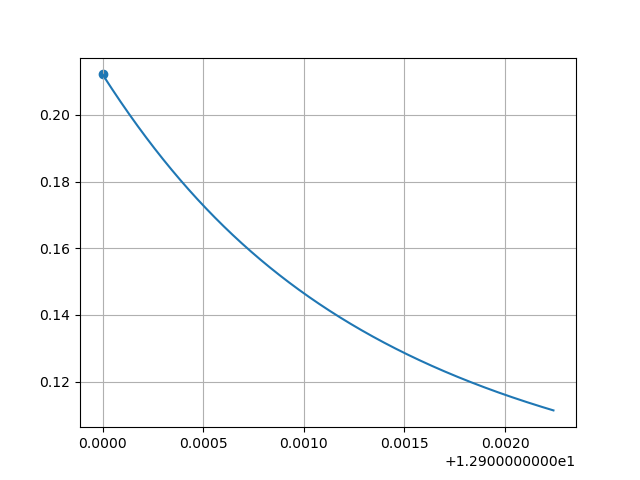

In [31]:
# evolve without animating
n_grid = 50
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e0
r = 1e-4

lbd_spl = 15.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
n_cells = len(cell_boundaries) - 1

rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)


g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

# _, stat = fv.evolve_P_from_gauss(10000, 100, 0.01, n_grid, fact, kappa, k, eps, lbd_spl, r, 5, 1)

P_ini = 1 * np.exp( - (cell_centers - 0.86 * lbd_spl)**2 / 0.3**2)

plt.close('all')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
fig, ax = plt.subplots()
    
# precondition
n_steps = 20000
dt = 1e-2
stride = 1

P1, stats0 = fv.evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
# evolve faster
n_steps = 10000000
dt = 1e-2
stride = 1000

P, stats = fv.evolve_P(n_steps, stride, P1, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)
    
i = 0
ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10])
ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
ax.scatter(stats0[1, 0], stats0[2, 0])
ax.grid()
plt.show()

In [33]:
# P_ini = 1 * np.exp( - (cell_centers - 0.86 * lbd_spl)**2 / 4.3**2)

# # precondition
# n_steps = 20000
# dt = 1e-2
# stride = 1

# P1, stats0 = fv.evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
# evolve faster
n_steps = 10000000
dt = 1e-2
stride = 10000

P, stats = fv.evolve_P(n_steps, stride, P, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)
    
i = 3
ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10])
ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
ax.scatter(stats0[1, 0], stats0[2, 0])


Evolving P : 100%|██████████| 10000000/10000000 [06:41<00:00, 24895.92it/s]


In [ ]:
fig, ax = plt.subplots()
ax.bar(cell_centers, P, width=dx_array, alpha=0.6, color='C0')
ax.bar(cell_centers, P_ini, width=dx_array, alpha=0.3, color='C1')
# ax.plot(cell_centers, 100*v_M(cell_centers, P, g_int_array, dx_array, kappa, k, eps), color='red', label='v_M')
# ax.set_yscale('log')
ax.grid()
ax.set_ybound(1e-5, 1)

Emerging scales: lbd_spl/2 = 8.00, lbd_max = 11.28, lbd_spl = 16.00


Evolving P : 100%|██████████| 10000000/10000000 [01:00<00:00, 164215.38it/s]


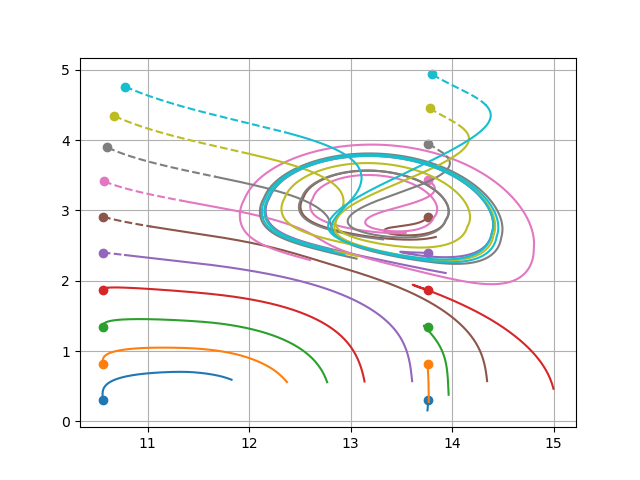

In [52]:
# evolve without animating (many initial positions)
n_grid = 30
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e0
r = 1e-4

lbd_spl = 16.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
n_cells = len(cell_boundaries) - 1

rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)


g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

plt.close('all')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
fig, ax = plt.subplots()
  
for i, _sig in enumerate(np.linspace(0.3, 5.0, 10, endpoint=True)):
    P_ini = np.exp( - (cell_centers - 0.86 * lbd_spl)**2 / _sig**2 / 2)
    
    # precondition
    n_steps = 20000
    dt = 1e-2
    stride = 1

    P1, stats0 = fv.evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
        
    # evolve faster
    n_steps = 10000000
    dt = 1e-2
    stride = 1000

    P, stats = fv.evolve_P(n_steps, stride, P1, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)
        
    ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10], linestyle='--')
    ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
    ax.scatter(stats0[1, 0], stats0[2, 0])

    P_ini = np.exp( - (cell_centers - 0.66 * lbd_spl)**2 / _sig**2 / 2)
    
    # precondition
    n_steps = 20000
    dt = 1e-2
    stride = 1

    P1, stats0 = fv.evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
        
    # evolve faster
    n_steps = 10000000
    dt = 1e-2
    stride = 1000

    P, stats = fv.evolve_P(n_steps, stride, P1, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)
        
    ax.plot(stats0[1, :], stats0[2, :], color=colors[i%10], linestyle='--')
    ax.plot(stats[1, :], stats[2, :], color=colors[i%10])
    ax.scatter(stats0[1, 0], stats0[2, 0], color=colors[i%10])

ax.grid()

In [2]:
# evolve without animating (many initial positions)
n_grid = 25
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0

n_epsilon = 3
epsilon_range = np.logspace(-2, 0, n_epsilon, endpoint=True)

r = 1e-4

n_lbd_spl = 2
lbd_spl_range = np.linspace(12, 30, n_lbd_spl)

params_list = [(Drho, Dc, T, epsilon, r, lbd_spl) for lbd_spl in lbd_spl_range for epsilon in epsilon_range]

n_mu = 1
n_sig = 2
ini_cond_list = [(_mu_fact, _sig) for _sig in np.linspace(0.3, 5.0, n_sig, endpoint=True) for _mu_fact in np.linspace(0.7, 0.9, n_mu, endpoint=True)]

n_steps = 1000000
dt = 1e-1
stride = 1000

results = np.empty((len(params_list), len(ini_cond_list), 2), dtype=object)

for i, params in tqdm(enumerate(params_list)):
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)

    for j, ini_cond in enumerate(ini_cond_list):
        mu_fact, sig = ini_cond
        mu = mu_fact * lbd_spl
        P_final, stats = fv.evolve_P_from_gauss(n_steps, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
        results[i, j, 0] = P_final
        results[i, j, 1] = stats

6it [00:00, 95.01it/s]


In [29]:
n_grid = 25
fact = 1

tqdm_bool = True
Drho = 0.1
Dc = 1.0
T = 5.0

n_epsilon = 13
epsilon_range = np.logspace(-2, 0, n_epsilon, endpoint=True)

r = 1e-4

n_lbd_spl = 18
lbd_spl_range = np.linspace(12, 30, n_lbd_spl)

params_list = [(Drho, Dc, T, epsilon, r, lbd_spl) for lbd_spl in lbd_spl_range for epsilon in epsilon_range]

_perturb = 0.05
n_precondition = 2000
check_fact = 10

n_steps = 50000000
dt = 1e-1
stride = 1000


# at each parameter set:

results = np.empty((len(params_list), 2, 2), dtype=object)

_iter = tqdm(enumerate(params_list), total=len(params_list)) if tqdm_bool else enumerate(params_list)
for i, params in _iter:
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)

    cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
    rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)    
    g_int_array= fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

    x_ss, P_ss = get_P_ss_robust(kappa, k, eps, lbd_spl, r)

    if P_ss is None:
        mu = 0.85 * lbd_spl
        sig = 5.0
        P_ini = np.exp(- 0.5 * (cell_centers - mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)
    else:
        mu = 0.85 * lbd_spl
        sig = 0.5
        P_ini = (1 - _perturb) * get_ss_initial_condition(cell_centers, x_ss, P_ss) + _perturb * np.exp(- 0.5 * (cell_centers - mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)


    # preconditioning steps
    P_preconditioned, stats0 = fv.evolve_P(n_precondition, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize=True, tqdm_bool=False)

    n_steps_batch = n_steps // check_fact
    P_final_current = P_preconditioned.copy()
    for _k in range(check_fact):
        P_final_current, stats1 = fv.evolve_P(n_steps_batch, stride, P_final_current, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize=True, tqdm_bool=False)
        stats0 = np.concatenate((stats0, stats1), axis=1)

        if _k > 1 and fv.check_fall(stats0[1, :], stats0[2, :]):  
            print('Realization skipped, going to trivial eq. ')
            break

        elif _k > 1 and fv.check_loop(stats0[1, :], stats0[2, :]):
            print('Realization skipped, going to chaos eq. ')
            break
    
    results[i, 0, 0] = params
    results[i, 0, 1] = stats0

#   use a low sigma gauss initial condition
    mu = 0.85 * lbd_spl
    sig = 0.3
    P_ini = np.exp(- 0.5 * (cell_centers - mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

#   # preconditioning steps
    P_preconditioned, stats0 = fv.evolve_P(n_precondition, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize=True, tqdm_bool=False)

    n_steps_batch = n_steps // check_fact
    P_final_current = P_preconditioned.copy()
    for _k in range(check_fact):
        P_final_current, stats1 = fv.evolve_P(n_steps_batch, stride, P_final_current, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, normalize=True, tqdm_bool=False)
        stats0 = np.concatenate((stats0, stats1), axis=1)

        if _k > 1 and fv.check_fall(stats0[1, :], stats0[2, :]):  
            print('Realization skipped, going to trivial eq. ')
            break

        elif _k > 1 and fv.check_loop(stats0[1, :], stats0[2, :]):
            print('Realization skipped, going to chaos eq. ')
            break

    results[i, 1, 0] = params
    results[i, 1, 1] = stats0

# np.save('marco.npy', results)


  0%|          | 0/234 [00:00<?, ?it/s]/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:144: RuntimeWarning: invalid value encountered in divide
  Tx = dxdt / tnorm
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:145: RuntimeWarning: invalid value encountered in divide
  Ty = dydt / tnorm
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:149: RuntimeWarning: divide by zero encountered in divide
  dTxds = np.gradient(Tx, dt) / tnorm
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:149: RuntimeWarning: invalid value encountered in divide
  dTxds = np.gradient(Tx, dt) / tnorm
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:150: RuntimeWarning: divide by zero encountered in divide
  dTyds = np.gradient(Ty, dt) / tnorm
/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSFVEvolve.py:150: RuntimeWarning: invalid value encountered in divide
  dTyds = np.gradient(Ty, dt) / tnorm
/home/n/Natan.Dom

Realization skipped, going to chaos eq. 


  0%|          | 1/234 [02:20<9:03:50, 140.05s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  1%|          | 2/234 [04:37<8:55:49, 138.58s/it]

Realization skipped, going to chaos eq. 


/home/n/Natan.Dominko/Documents/code/peaks_analysis/MFKSSteadyState.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, g_avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)


Realization skipped, going to chaos eq. 


  1%|▏         | 3/234 [06:54<8:51:04, 137.94s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  2%|▏         | 4/234 [09:18<8:57:21, 140.18s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  2%|▏         | 5/234 [11:48<9:08:03, 143.60s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  3%|▎         | 6/234 [14:25<9:23:12, 148.21s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  3%|▎         | 7/234 [17:38<10:15:54, 162.79s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  3%|▎         | 8/234 [20:48<10:46:36, 171.67s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  4%|▍         | 9/234 [24:00<11:06:52, 177.83s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  4%|▍         | 10/234 [26:45<10:49:08, 173.88s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  5%|▍         | 11/234 [29:08<10:11:53, 164.64s/it]

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  5%|▌         | 12/234 [31:24<9:37:06, 155.97s/it] 

Realization skipped, going to chaos eq. 
Realization skipped, going to chaos eq. 


  6%|▌         | 13/234 [33:51<9:24:18, 153.21s/it]

Realization skipped, going to chaos eq. 


  6%|▌         | 13/234 [34:47<9:51:33, 160.60s/it]


KeyboardInterrupt: 

In [112]:
# fig, ax = plt.subplots()

# for i in range(np.shape(results)[0]):
#     if i != 7:
#         continue
#     params = results[i, 0, 0]
#     print(params)

#     Drho, Dc, T, epsilon, r, lbd_spl = params
#     kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
#     lbd_max = -1 / k * np.log(eps / k / kappa)
#     print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')
#     ax.axvline(lbd_max, color='forestgreen', label='argmax v')
#     ax.axvline(lbd_spl, color='gold', label='lbd_spl')

#     for j in range(0,2):
#         stats = results[i, j, 1]
#         if fv.check_fall(stats[1,:], stats[2,:], dt):
#             ax.plot(stats[1,:], stats[2,:], 'r-')
#         elif fv.check_loop(stats[1,:], stats[2,:], dt):
#             ax.plot(stats[1,:], stats[2,:], 'b-')
#         else:
#             ax.plot(stats[1,:], stats[2,:], 'k-')

# ax.grid()
# ax.legend()
# # ax.set_yscale('log')
# plt.show()

from ipywidgets import Layout, widgets, interact
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

    
# Function to create the streamline plot
def plot_vector_field(i):

    plt.close('all')
    fig, ax = plt.subplots()

    params = results[i, 0, 0]
    print(f"epsilon = {params[3]:.1e}")

    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
    lbd_max = -1 / k * np.log(eps / k / kappa)
    print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')
    ax.axvline(lbd_max, color='k', label='argmax v')
    ax.axvline(lbd_spl, color='gold', label='lbd_spl')

    for j in range(0,2):
        stats = results[i, j, 1]
        if fv.check_fall(stats[1,:], stats[2,:], dt):
            ax.plot(stats[1,:], stats[2,:], 'b-')
        elif fv.check_loop(stats[1,:], stats[2,:], dt):
            ax.plot(stats[1,:], stats[2,:], 'r-')
        else:
            ax.plot(stats[1,:], stats[2,:], 'g-')



    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()


# Interactive sliders
i_slider = widgets.IntSlider(value=0,  min=0, max=np.shape(results)[0]-1, step=1, description='i', layout=Layout(width='500px'), continuous_update=False)

# Create interactive plot
interactive_plot = interact(plot_vector_field, 
                            i=i_slider)

display(interactive_plot)


interactive(children=(IntSlider(value=0, continuous_update=False, description='i', layout=Layout(width='500px'…

<function __main__.plot_vector_field(i)>

No such comm: cea1549ea357454891d5df1d05ba9f90


No such comm: 11eba8082fcf44c88af4b89995c4dcbc


No such comm: 8fbec3528eeb46c88ac61708fa2a5b68


No such comm: ad9adda1fa5342e3bff5654cb6a61eca


No such comm: 517328752e324a2583e6dcb979c74910


No such comm: 6f7022222933404ba723f6e7830f3773


In [66]:
plt.close('all')

In [7]:
results = np.load('res321.npy', allow_pickle=True)

In [26]:
print(results[0,0,0].shape)

(75,)


ValueError: too many values to unpack (expected 6)

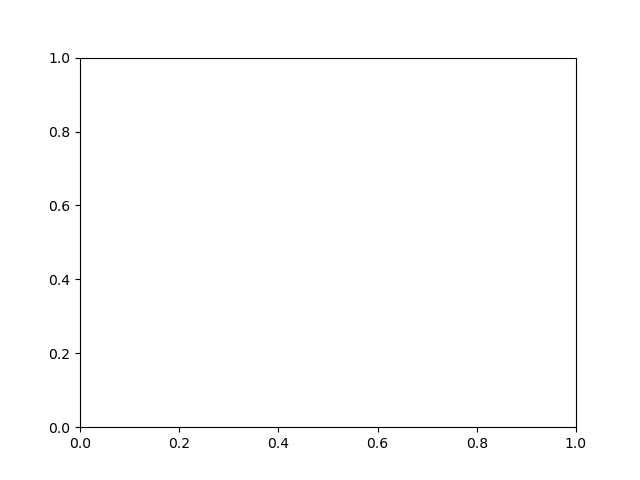

In [9]:
fig, ax = plt.subplots()
for i in range(np.shape(results)[0]):
    # if i != 3: continue
    params = results[i, 0, 0]
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
    
    n_hi, n_mid, n_lo = 0, 0, 0
    for j in range(0,2):
        stats = results[i, j, 1]
        if fv.check_fall(stats[1,:], stats[2,:]):
            n_lo += 1
        elif fv.check_loop(stats[1,:], stats[2,:]): 
            n_hi += 1            
        else:
            n_mid += 1
 
    # ax.scatter([epsilon], [lbd_spl], c=[(n_hi/2, 0, 0)], s=1000)
    # ax.scatter([epsilon], [lbd_spl], c=[(0, n_mid/2, 0)], s=400)
    # ax.scatter([epsilon], [lbd_spl], c=[(0, 0, n_lo/2)], s=100)
    ax.scatter([epsilon], [lbd_spl], c=[(n_hi/2, n_mid/2, n_lo/2)], s=200)
    print(f"Parameter set {i + 1} of {len(params_list)}: {n_hi = }, {n_mid = }, {n_lo = }")


ax.grid()
ax.set_xscale('log')
plt.show()


In [91]:
plt.close('all')

In [28]:
from MFKSSteadyState import parameter_control
def get_P_ss_robust(kappa, k, eps, lbd_spl, r, dx=1e-3, lbd_lim_left=1e-1, verbose=False, max_count=50, tol=1e-12, xmax_add_list=[1.0, 3.0, 5.0]):
    if parameter_control(kappa, k, eps, lbd_spl):
        for xmax_add in xmax_add_list:
            try:
                x_ss, P_ss = get_P_ss(lbd_spl + xmax_add, kappa, k, eps, lbd_spl, r, dx=dx, lbd_lim_left=lbd_lim_left, verbose=verbose, max_count=max_count, tol=tol)
                # make sure to not use diverging initial conditions
                if np.any(P_ss < 0):
                    raise ValueError
                else:
                    return x_ss, P_ss
            except:
                pass 
        return None, None
    else:
        return None, None

from scipy.interpolate import Akima1DInterpolator
def get_ss_initial_condition(x_array, x_ss, P_ss):
    P_out = np.zeros_like(x_array)
    mask = (x_array >= np.min(x_ss)) * (x_array <= np.max(x_ss))
    P_out[mask] = Akima1DInterpolator(x_ss, P_ss)(x_array[mask])
    if np.any(P_out < 0):
        print('problem')
    return P_out

In [1]:
from utils import reparameterize
reparameterize(0.1, 1.0, 5.0, 1e-1, 0)

(1.5191835884530853, 1.0, 1.9189364728418242e-06, array(7.11094559), 0)

In [100]:
results = np.load("res321.npy", allow_pickle=True)

ValueError: too many values to unpack (expected 6)

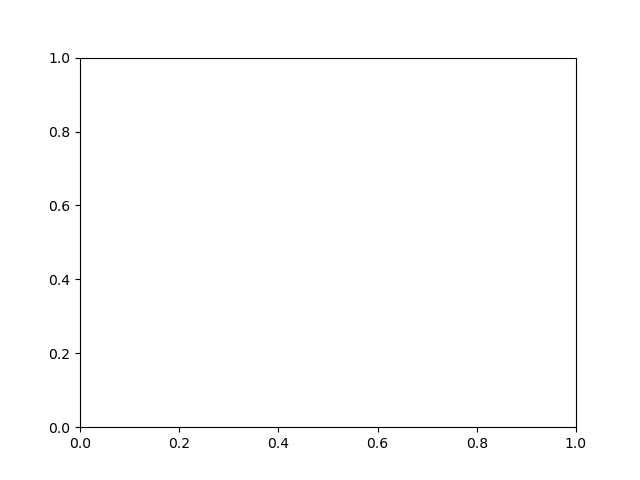

In [12]:
fig, ax = plt.subplots()
for i in range(np.shape(results)[0]):
    params = results[i, 0, 0]
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
    n_hi, n_mid, n_lo = 0, 0, 0
    for j in range(2):
        mu_fact, sig = ini_cond
        mu = mu_fact * lbd_spl
        # P_final = results[i, j, 0]
        stats = results[i, j, 1]
        if fv.check_fall(stats[1,:], stats[2,:]):
            n_lo += 1
        elif fv.check_loop(stats[1,:], stats[2,:]): 
            n_hi += 1            
        else:
            n_mid += 1
    ax.scatter([epsilon], [lbd_spl], c=[(n_hi/len(ini_cond_list), 0, 0)], s=1000)
    ax.scatter([epsilon], [lbd_spl], c=[(0, n_mid/len(ini_cond_list), 0)], s=400)
    ax.scatter([epsilon], [lbd_spl], c=[(0, 0, n_lo/len(ini_cond_list))], s=100)
    print(f"Parameter set {i + 1} of {len(params_list)}: {n_hi = }, {n_mid = }, {n_lo = }")
ax.grid()
ax.set_xscale('log')
plt.show()


(0.1, 1.0, 5.0, 0.01668100537200059, 0.0001, 20.0)
Emerging scales: lbd_spl/2 = 10.00, lbd_max = 15.37, lbd_spl = 20.00
[1.39891663 1.40228618 1.40565852 1.4090341  1.41241222 1.41579302
 1.41917691 1.42256358 1.06847812 0.71279114]
[2.27736596 2.28664546 2.29596254 2.30531731 2.31470985 2.32414026
 2.33360863 2.34311505 1.76314076 1.17771251]
[0.83156723 0.83254819 0.83353157 0.83451738 0.83550564 0.83649636
 0.83748955 0.83848523 0.62942085 0.41981917]


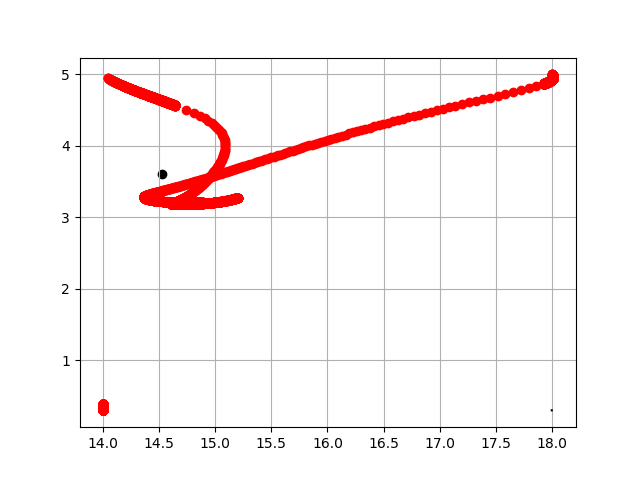

In [10]:
fig, ax = plt.subplots()
i = 41
params = params_list[i]
print(params)
Drho, Dc, T, epsilon, r, lbd_spl = params
kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)
lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')
for j, ini_cond  in enumerate(ini_cond_list):
    mu_fact, sig = ini_cond
    mu = mu_fact * lbd_spl
    # P_final = results[i, j, 0]
    stats = results[i, j, 1]
    if fv.check_loop(stats[1,:], stats[2,:], dt=dt):
        ax.plot(stats[1, :], stats[2, :], 'ko')
    elif fv.check_fall(stats[1,:], stats[2,:], dt=dt):
        ax.plot(stats[1, :], stats[2, :], color='k')
    else:
        ax.plot(stats[1, :], stats[2, :], 'ro')


try:
    _xx, _yy = get_P_ss(lbd_spl+5, kappa, k, eps, lbd_spl, r)
    _m = np.trapz(_xx * _yy, _xx)
    _s = np.sqrt(np.trapz((_m - _xx)**2 * _yy, _xx))
    ax.scatter([_m], [_s], c=['k'])
except:
    pass
ax.grid()
plt.show()


In [127]:
plt.close('all')

In [ ]:
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.03
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1.2
k = 1.2
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 2.3**2)

In [ ]:
# show effect of timesteps 
fig, ax = plt.subplots()

# prepare  
t_final = 100

# baseline
n_steps = 1000000
dt = t_final / n_steps
_, stats_full = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

n_stepss = [100000, 10000, 1000]
for ls_ind, n_steps in enumerate(n_stepss):
    dt = t_final / n_steps
    t_array = np.arange(n_steps)*dt 

    _, stats = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array, np.abs(stats[i,:] - stats_full[i, ::10**(1 + ls_ind)]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {dt = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'dt: {t_final / n_stepss[i]}') for i in range(len(n_stepss))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to small timestep')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# show effect of stride 
from matplotlib.lines import Line2D
fig, ax = plt.subplots()

# prepare
n_steps = 10000
dt = 1e-2
P_first, _ = evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
n_steps = 100000
dt = 1e-2
t_array = np.arange(n_steps)*dt 

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

_, stats_full = evolve_P(n_steps, 1, P_first, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)

strides = [10, 100, 1000, 10000]
for ls_ind, stride in enumerate(strides):
    _, stats = evolve_P(n_steps, stride, P_first, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array[::stride], np.abs(stats[i,:] - stats_full[i, ::stride]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {stride = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'Stride: {strides[i]}') for i in range(len(strides))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to stride 1')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from matplotlib.colors import LogNorm
from MFKSSteadyState import get_P_ss, parameter_control
from MFKSGaussClosure import mu_sig_prime, get_traj

num_frames = 1000000
stride = 1000
dt = 0.01
n_grid = 40
fact = 1

x = np.linspace(0, 10, 100)
y = np.linspace(0.001, 2.5, 100)
X, Y = np.meshgrid(x, y)
mask = X - 2*Y < 0


# Define a function to update the plot
def update_plot(lbd_spl, r, kappa, k, xmax, eps, dx, mu, sig):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
    if parameter_control(kappa, k, eps, lbd_spl):
        lbd_array, P_array = get_P_ss(xmax, kappa, k, eps, lbd_spl, r, dx)
        ax1.plot(lbd_array, P_array, 'k', label='Steady state')
        # x_range, P_range, _ = get_P_ss(xmax, kappa, k, 0.0, lbd_spl, r, dx)
        # plt.plot(x_range, P_range, 'r--', label='Steady state eps=0')

    # get and plot full evolution
    cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
    P_final, stats_evo = evolve_P_from_gauss(num_frames, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
    ax1.step(cell_centers, np.exp(-0.5*(cell_centers-mu)**2/sig**2)/np.sqrt(2*np.pi*sig**2), where='mid', color='gold', label=f'P(λ,T = 0)')
    ax1.bar(cell_centers, P_final, width=dx_array, color='firebrick', alpha=0.6, label=f'P(λ,T = {num_frames*dt})')
    ax2.plot(stats_evo[1, :], stats_evo[2, :], color='firebrick', label='full evo')

    # get and plot gaussian field 
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    U[mask] = V[mask] = np.nan
    strm = ax2.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-7, 1e-1))
    ax2.scatter([mu], [sig], c='gold', label='initial')

    # get and plot specific gaussian realisation
    # mu_gauss, sig_gauss = get_traj(mu, sig, kappa, k, eps, lbd_spl, r)
    # ax2.plot(mu_gauss, sig_gauss, 'k', label='gaussian evo')
    
    ax1.set_xlabel('lambda')
    ax1.set_xlim(0, 2 * lbd_spl)
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlim(np.min(x),np.max(x))
    ax2.set_ylim(np.min(y),np.max(y))
    ax2.set_xlabel('mu')
    ax2.set_ylabel('sig')
    ax2.legend()
    ax2.grid()
    
    fig.colorbar(strm.lines)
    
    plt.tight_layout()
    plt.show()

# Create interactive sliders
lbd_spl_slider = FloatSlider(value=7.5, min=6.0, max=9.0, step=0.1, description='λ:', layout=Layout(width='500px'), continuous_update=False)
r_slider = FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='r:', layout=Layout(width='500px'), continuous_update=False)
kappa_slider = FloatSlider(value=1.2, min=1.0, max=1.5, step=0.1, description='κ:', layout=Layout(width='500px'), continuous_update=False)
k_slider = FloatSlider(value=1.0, min=0.5, max=1.0, step=0.1, description='k:', layout=Layout(width='500px'), continuous_update=False)
xmax_slider = IntSlider(value=30, min=10, max=50, step=1, description='xmax:', layout=Layout(width='500px'), continuous_update=False)
eps_slider = FloatSlider(value=3e-3, min=0, max=1e-2, step=1e-4, description='eps:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
dx_slider = FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='dx:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
mu_slider = FloatSlider(value=6, min=2.0, max=8.0, step=0.1, description='mu_ini:', layout=Layout(width='500px'), continuous_update=False)
sig_slider = FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='sig_ini:', layout=Layout(width='500px'), continuous_update=False)

# Use interact to create the interactive plot
interact(update_plot, lbd_spl=lbd_spl_slider, r=r_slider, kappa=kappa_slider, k=k_slider, xmax=xmax_slider, eps=eps_slider, dx=dx_slider, mu=mu_slider, sig=sig_slider)
    

In [ ]:
# reparameterized to real parameters
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Layout
from matplotlib.colors import LogNorm
from MFKSSteadyState import get_P_ss, parameter_control, get_lbd_inf, g
from MFKSGaussClosure import mu_sig_prime, get_traj

num_frames = 1000000
stride = 10000
dt = 0.01
n_grid = 40
fact = 1


# Define a function to update the plot
def update_plot(Drho, Dc, T, epsilon, r, xmax, dx, mu, sig):

    kappa, k, eps, lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))
    if parameter_control(kappa, k, eps, lbd_spl):
        lbd_array, P_array = get_P_ss(xmax, kappa, k, eps, lbd_spl, r, dx)
        ax1.plot(lbd_array, P_array, 'k', label='Steady state')
        ss_mean = np.trapz(P_array * lbd_array, lbd_array)
        ax2.scatter([ss_mean], [np.sqrt(np.trapz(P_array * (lbd_array - ss_mean)**2, lbd_array))], color='green', label='Steady state')
        # g_avg = np.trapz(P_array * g(lbd_array, kappa, k, eps), lbd_array)
        # lbd_inf = get_lbd_inf(g_avg, kappa, k, eps)
        # print(f'{lbd_inf = }')
    # else:
        # lbd_inf = 20.
        # x_range, P_range, _ = get_P_ss(xmax, kappa, k, 0.0, lbd_spl, r, dx)
        # plt.plot(x_range, P_range, 'r--', label='Steady state eps=0')

    # get and plot full evolution
    cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, n_grid, fact)
    P_final, stats_evo = evolve_P_from_gauss(num_frames, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
    ax1.step(cell_centers, np.exp(-0.5*(cell_centers-mu)**2/sig**2)/np.sqrt(2*np.pi*sig**2), where='mid', color='gold', label=f'P(λ,T = 0)')
    ax1.bar(cell_centers, P_final, width=dx_array, color='firebrick', alpha=0.6, label=f'P(λ,T = {num_frames*dt})')
    ax2.plot(stats_evo[1, :], stats_evo[2, :], color='firebrick', label='full evo')
    
    # get and plot gaussian field 
    x = np.linspace(0, 30, 100)
    y = np.linspace(0.001, 5, 100)
    X, Y = np.meshgrid(x, y)
    # mask = X - 2*Y < 0
    U, V = mu_sig_prime((X, Y), kappa, k, eps, lbd_spl, r)
    # U[mask] = V[mask] = np.nan
    strm = ax2.streamplot(X, Y, U, V, color=np.sqrt(U**2 + V**2), density=1.6, cmap='winter', norm=LogNorm(1e-7, 1e-1))
    ax2.scatter([mu], [sig], c='gold', label='initial')

    # _a = r / (2 * np.sqrt(2 * np.pi))
    # _b = kappa * (np.exp(-k * x) - 1) - r / 4 * (lbd_spl - x)
    # _c = x * kappa * np.exp(-k * x) / np.sqrt(2 * np.pi)
    
    # ax2.plot(x, (-_b - np.sqrt(_b**2 - 4*_a*_c))/2/_a, 'k--')

    # get and plot specific gaussian realisation
    # mu_gauss, sig_gauss = get_traj(mu, sig, kappa, k, eps, lbd_spl, r)
    # ax2.plot(mu_gauss, sig_gauss, 'k', label='gaussian evo')
    # ax1.axvspan(xmin=lbd_inf, xmax=np.max(lbd_array), color='gray', alpha=0.3)
    
    ax1.set_xlabel('lambda')
    _xlim_up = min(2*lbd_spl, 2*np.max(cell_centers), 20)
    ax1.set_xlim(0, _xlim_up)
    ax1.legend()
    ax1.grid()
    
    ax2.set_xlim(np.min(x),np.max(x))
    ax2.set_ylim(np.min(y),np.max(y))
    ax2.set_xlabel('mu')
    ax2.set_ylabel('sig')
    ax2.legend()
    ax2.grid()
    
    fig.colorbar(strm.lines)
    
    plt.tight_layout()
    plt.show()

# Create interactive sliders
Drho_slider = FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description='D_rho:', layout=Layout(width='500px'), continuous_update=False)
Dc_slider = FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='D_c:', layout=Layout(width='500px'), continuous_update=False)
T_slider = FloatSlider(value=5.0, min=0.5, max=10.0, step=0.1, description='T:', layout=Layout(width='500px'), continuous_update=False)
epsilon_slider = FloatSlider(value=1e-2, min=0, max=1e-1, step=1e-3, description='epsilon:', readout_format='.2e', layout=Layout(width='500px'), continuous_update=False)
r_slider = FloatSlider(value=0.04, min=0.001, max=1.0, step=1e-3, description='r:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
xmax_slider = IntSlider(value=30, min=10, max=50, step=1, description='xmax:', layout=Layout(width='500px'), continuous_update=False)
dx_slider = FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='dx:', readout_format='.1e', layout=Layout(width='500px'), continuous_update=False)
mu_slider = FloatSlider(value=6, min=2.0, max=22.0, step=0.1, description='mu_ini:', layout=Layout(width='500px'), continuous_update=False)
sig_slider = FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='sig_ini:', layout=Layout(width='500px'), continuous_update=False)

# Use interact to create the interactive plot
interact(update_plot, Drho=Drho_slider, Dc=Dc_slider, T=T_slider, epsilon=epsilon_slider, r=r_slider, xmax=xmax_slider, dx=dx_slider, mu=mu_slider, sig=sig_slider) 

## Trash

In [ ]:
# steady state
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy.integrate import cumulative_trapezoid, solve_ivp
from scipy.interpolate import Akima1DInterpolator
from scipy.optimize import bisect
from scipy.special import spence
from tqdm import tqdm

def rate(lbd, lbd_spl, r):
    return np.maximum(0, r * (lbd - lbd_spl))

def g(x, kappa, k, eps):
    return kappa * np.exp(-k*x) + eps * x

def v_Mss(x, avg, kappa, k, eps):
    return avg - g(x, kappa, k, eps)

def get_lbd_inf(avg, kappa, k, eps):
    if eps == 0.:
        return np.inf
    else:
        xleft = -1 / k * np.log(eps / kappa / k) # location of maximum of v_Mss
        assert v_Mss(xleft, avg, kappa, k, eps) > 0, f"Assumed v_M(.) > 0 but instead is {v_Mss(xleft, avg, kappa, k, eps)}"
        xright= avg / eps + 1 # zero if k = inf
        return bisect(v_Mss, xleft, xright, args=(avg, kappa, k, eps)) - 3e-12 # ensure the root found is always < real root
        
def get_lbd_0(avg, kappa, k, eps):
    if eps == 0.:
        return - 1 / k * np.log(avg / kappa)
    else:
        xright = -1 / k * np.log(eps / kappa / k) # location of maximum of v_Mss
        assert v_Mss(xright, avg, kappa, k, eps) > 0,  f"Assumed v_M(.) > 0 but instead is {v_Mss(xright, avg, kappa, k, eps)}"
        xleft= -1 / k * np.log(avg/kappa) # zero if eps = 0
        return bisect(v_Mss, xleft, xright, args=(avg, kappa, k, eps)) + 3e-12 # ensure the root found is always > real root

def cumulative_trapezoid_reversed(y, x, final_value):
    return cumulative_trapezoid(y[::-1], x[::-1], initial=0)[::-1] + final_value

def parameter_control(kappa, k, eps, lbd_spl):
    avg_min = g(lbd_spl, kappa, k, eps)
    avg_max = g(lbd_spl/2, kappa, k, eps)
    if avg_min < avg_max:
        return True
    else:
        print("Parameters do not produce a steady state solution."  )
        return False


def p_hom_global(x, x_left, x_right, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    if eps == 0.0:
        y = k * (x - lbd_spl)
        u0= kappa / avg * np.exp(-k * lbd_spl)
        print(u0)
        u = u0 * np.exp(-y)
        res = np.exp(- 0.5 * r / avg / k**2 * (
            0.5 * np.log(u/u0)**2 -
            np.log(1 - u) * np.log(u/u0) -
            spence(1 - u) + 
            spence(1 - u0)))
        return np.where(x <= x_left, 1, res)
    
    lbd_upper = lbd_inf#min(lbd_inf, -1 / k * np.log(1e-15/kappa))
    av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
    x = np.asarray(x)  # Ensure x is a numpy array
    res = np.where((x > x_left) & (x < x_right), np.exp(-0.5*av_int.sol(x)), np.nan)
    return np.where(x <= x_left, 1, np.where(x >= x_right, 0, res))[0]

def log_p_hom_global(x, x_left, x_right, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    if eps == 0.0:
        u0 = kappa * np.exp(-k * lbd_spl) / avg
        # res =  np.exp(- 0.5 * r / avg / k**2 * (
        #     0.5 * k**2 * (x - lbd_spl)**2 +
        #     k * (x - lbd_spl) * np.log(1 - u0 * np.exp(-k * (x - lbd_spl))) - 
        #     spence(u0 * np.exp(-k * (x - lbd_spl))) + 
        #     spence(u0) 
        # ))
        res =  np.exp(- 0.5 * r / avg * (
            0.5 * (x - lbd_spl)**2 - 
            1 / k**2  * spence(1 - u0 * np.exp(-k * (x - lbd_spl))) + 
            1 / k**2  * spence(1 - u0) 
        )) * (1 - u0 * np.exp(-k * (x - lbd_spl))) ** (-0.5 * r / avg / k * (x - lbd_spl))
        return np.where(x <= x_left, 1, res)
    
    lbd_upper = lbd_inf#min(lbd_inf, -1 / k * np.log(1e-15/kappa))
    av_int = solve_ivp(lambda t, y: rate(t, lbd_spl, r) / v_Mss(t, avg, kappa, k, eps), t_span=(lbd_spl, lbd_upper), y0=[0.0], dense_output=True)
    x = np.asarray(x)  # Ensure x is a numpy array
    res = np.where((x > x_left) & (x < x_right), -0.5*av_int.sol(x), np.nan)
    return np.where(x <= x_left, 0, np.where(x >= x_right, -np.inf, res))[0]


def get_particular(lbd_array_current, lbd_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    
    # interpolate P on the known interval
    P_full_intepr = Akima1DInterpolator(lbd_array_full, P_array_full)

    # evaluate particular_prime on lbd_array_current
    rate_P_2 = 2 * rate(2 * lbd_array_current, lbd_spl, r) * P_full_intepr(2 * lbd_array_current)
    p_hom_array = p_hom_global(lbd_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    with np.errstate(divide='ignore', invalid='ignore'): # safe division
        particular_prime = np.true_divide(rate_P_2, p_hom_array)
        particular_prime = np.nan_to_num(particular_prime, nan=0.0)

    # boundary condition (safe)
    final = -1.0
    p_hom_0 = p_hom_global(x_array_full[0], lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    if p_hom_0 > 0.0:
        final += P_array_full[0] * v_Mss(x_array_full[0], avg, kappa, k, eps) / p_hom_0
        
    # integrate from above
    return cumulative_trapezoid_reversed(particular_prime, lbd_array_current, final_value=final) 


def P_solve(x_array_current, x_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r):
    # given P on some array, estimate it on another array 
    # interpolate on the known interval
    P_full_intepr = Akima1DInterpolator(x_array_full, P_array_full)

    rate_P_2 = 2 * rate(2 * x_array_current, lbd_spl, r) * P_full_intepr(2 * x_array_current)

    p_hom_array = p_hom_global(x_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)

    # safe division
    with np.errstate(divide='ignore', invalid='ignore'): 
        integrand = np.true_divide(rate_P_2, p_hom_array)
        integrand = np.nan_to_num(integrand, nan=0.0)

    # ensure continuity
    final = -1.0
    p_hom_0 = p_hom_global(x_array_full[0], lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
    if p_hom_0 > 0.0:
        final += P_full_intepr(x_array_full[0]) * v_Mss(x_array_full[0], avg, kappa, k, eps) / p_hom_0
        
    # integrate from above
    particular = cumulative_trapezoid_reversed(integrand, x_array_current, final_value=final) 
    if np.all(v_Mss(x_array_current, avg, kappa, k, eps) > 0):
        # print('Used log divide')
        res = np.exp(log_p_hom_global(x_array_current, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r) - 
                         np.log(v_Mss(x_array_current, avg, kappa, k, eps)))
    else:
        # safe division
        with np.errstate(divide='ignore', invalid='ignore'):
            res = np.true_divide(p_hom_array, v_Mss(x_array_current, avg, kappa, k, eps))
            res = np.nan_to_num(res, nan=0.0)


    return res * (np.ones_like(x_array_current) + particular)


def cascade_solve_P(lbd_max, lbd_inf, avg, kappa, k, eps, lbd_spl, r, dx, lbd_lim_left, verbose):    

    # if lbd_inf is outside the interval, inform the user of the approximation
    if lbd_max < lbd_inf: 
        print(f"We have lbd_max < lbd_inf, homogeneous approximation will be made. ")

    # on initial interval, the solution is homogeneous 
    lbd_max = min(lbd_max, lbd_inf)
    lbd_min, lbd_max = 0.5*lbd_max, lbd_max
    x_array_full = np.arange(lbd_min, lbd_max, dx)
    P_array_full = p_hom_global(x_array_full, lbd_spl, lbd_inf, lbd_inf, avg, kappa, k, eps, lbd_spl, r) / v_Mss(x_array_full, avg, kappa, k, eps)

    # update to new interval
    lbd_min, lbd_max = 0.5*lbd_min, lbd_min

    # loop through intervals to the left
    while lbd_min > lbd_lim_left:
        
        # solve on current interval
        x_array_current = np.arange(lbd_min, lbd_max, dx)
        P_array_current = P_solve(x_array_current, x_array_full, P_array_full, lbd_inf, avg, kappa, k, eps, lbd_spl, r)
        
        if verbose: 
            print(f'Dealing with {lbd_min, lbd_max}. Maximum of P here is {np.max(P_array_current)}. ')

        # update solutions
        x_array_full = np.concatenate((x_array_current, x_array_full))
        P_array_full = np.concatenate((P_array_current, P_array_full))
        
        # update interval
        lbd_min, lbd_max = 0.5*lbd_min, lbd_min

    return x_array_full, P_array_full


def find_leftmost_root(x_array, f_array):
    # Ensure that the input arrays are numpy arrays
    x_array = np.array(x_array)
    f_array = np.array(f_array)
    
    # Check for sign change and perform linear interpolation
    for i in range(len(f_array) - 1):
        if f_array[i] * f_array[i + 1] < 0:
            # Sign change detected between f_array[i] and f_array[i + 1]
            x1, x2 = x_array[i], x_array[i + 1]
            f1, f2 = f_array[i], f_array[i + 1]
            # Linear interpolation formula to find the root
            x_root = x1 - f1 * (x2 - x1) / (f2 - f1)
            return x_root
    
    # if no root found 
    raise ValueError('The array has no root.')

def get_P_ss(lbd_max, kappa, k, eps, lbd_spl, r, dx=1e-3, lbd_lim_left=1e-1, maxiter=50, verbose=False, max_count=20, tol=1e-8):

    assert parameter_control(kappa, k, eps, lbd_spl), "Parameters do not produce a steady state solution."  

    # find bracket for g_avg and define the initial guess
    g_avg_min = g(lbd_spl, kappa, k, eps)
    g_avg_max = g(lbd_spl/2, kappa, k, eps)
    g_avg_best = 0.5 * (g_avg_min + g_avg_max)
    if verbose: print(f"Bracket for g_avg ({g_avg_min}, {g_avg_max})")

    # initialize loop
    g_avg_prev = np.inf
    _counter = 0
    while np.abs(g_avg_best - g_avg_prev) > tol and _counter < max_count:
        lbd_0 = get_lbd_0(g_avg_best, kappa, k, eps)
        lbd_inf = get_lbd_inf(g_avg_best, kappa, k, eps)
        if verbose: print(f'Trying with {g_avg_best}, giving interval lbd_0 = {lbd_0},  lbd_inf = {lbd_inf}')

        # solve for P
        lbd_array, P_array = cascade_solve_P(lbd_max, lbd_inf, g_avg_best, kappa, k, eps, lbd_spl, r, dx, lbd_lim_left, verbose)

        # find root of v_M P
        vP_array = v_Mss(lbd_array, g_avg_best, kappa, k, eps) * P_array
        root = find_leftmost_root(lbd_array, vP_array)

        # set new g_avg_best
        g_avg_prev = g_avg_best
        g_avg_best = g(root, kappa, k, eps)
        # make sure we stay within the physical bracket
        assert g_avg_best > g_avg_min, f"g_avg_best too small, {g_avg_best = }, {g_avg_min = }"
        assert g_avg_best < g_avg_max, f"g_avg_best too big, {g_avg_best = }, {g_avg_max = }"

        _counter += 1
        
    # normalize 
    P_array /= np.trapz(P_array, lbd_array)
    
    return lbd_array, P_array, g_avg_best

In [ ]:
# ultimate speed up: matrix eigendecomposition
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = prepare_grid(lbd_spl, N, fact)
n_cells = len(cell_boundaries) - 1

r = 0.2
rmat = rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1 / (0.25 / 0.1**0.5 + 0.1 / 0.6 / 5)
k = 1 / np.sqrt(0.1)
print(f'{k = }, {kappa = }')
eps = 0.0

g_int_array = g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 1.3**2)
    
# precondition
n_steps = 200
dt = 1e-2
stride = 1
P0, stats0 = evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
fig, ax = plt.subplots()

n_steps = 1
dt = 1e-2
stride = 1
for i in range(2):
    P0, stats0 = evolve_P(n_steps, stride, P0, dt, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    # get rhs matrix
    rhs_mat = rhs(P0, cell_boundaries, g_int_array, dx_array, kappa, k, eps, rmat)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(rhs_mat)
    print(np.sort(eigenvalues.real)[-10:])
    
    # Identify the eigenvalue with the largest real part
    # index_of_largest_real_part = np.argsort(eigenvalues.real)[-1]
    indeces_of_largest_real_part = np.argsort(eigenvalues.real)[-10:]
    
    # Select the corresponding eigenvector
    for index_of_largest_real_part in indeces_of_largest_real_part:
        P0 = np.real(eigenvectors[:, index_of_largest_real_part])
        ax.plot(cell_centers, np.abs(P0)-0.1*i)
    print(f'Selected eigenvector with eigval {eigenvalues[index_of_largest_real_part]}')
